# Session 2: Introduction to SBI

In this notebook, we will implement and apply the rejection ABC algorithm to the Lotka-Volterra (LV) predator prey model. 

We have implemented a set of helper functions for running LV simulations and calculating summary statistics. 

Your central exercise will be to implement the rejection ABC algorithm yourself. 

In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
from tqdm import trange

# Helper functions
from simulators import (
    create_lotka_volterra_prior,
    generate_observed_data,
    lotka_volterra_simulator,
    simulate,
)
from utils import corner_plot

## Exercise 1: Implement rejection ABC for the Lotka-Volterra model

The Lotka-Volterra model describes predator-prey dynamics (e.g., wolves and deer):

- $\alpha$: prey birth rate
- $\beta$: predation rate  
- $\gamma$: predator death rate
- $\delta$: predator reproduction rate per prey consumed

\begin{align}
\frac{d(\text{prey})}{dt} &= \alpha \cdot \text{prey} - \beta \cdot \text{prey} \cdot \text{predator} \\
\frac{d(\text{predator})}{dt} &= \delta \cdot \text{prey} \cdot \text{predator} - \gamma \cdot \text{predator}
\end{align}

### Exploring the Simulator

Before we start inference, let's understand the simulator by visualizing its outputs:
1. **Time series dynamics**: How do populations evolve over time?
2. **Effect of parameters**: How do different parameters affect the dynamics?
3. **Summary statistics**: What features of the time series do we use for inference?

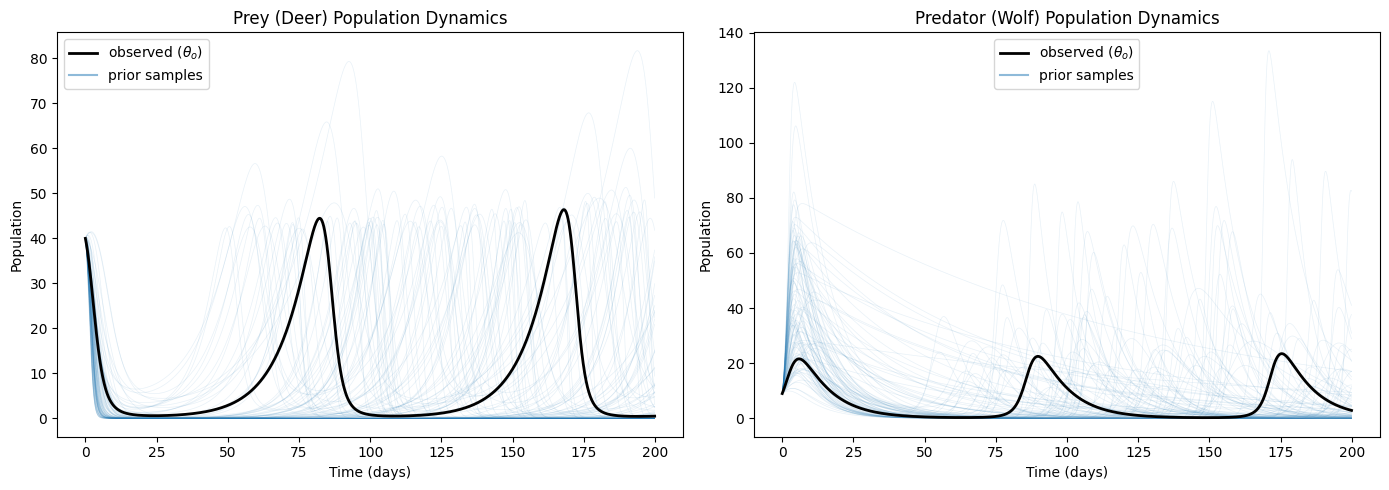

Ground truth parameters: α=0.100, β=0.020, δ=0.010, γ=0.100


In [2]:
# Set up prior and simulator
prior = create_lotka_volterra_prior()
x_o, theta_o = generate_observed_data(use_autocorrelation=True)

# Sample parameters from prior for visualization
n_simulations = 100
theta_prior = prior.sample((n_simulations,))

# Simulate time series for prior samples and ground truth
time = np.arange(0, 200, 0.1)
ts_observed = simulate(theta_o.numpy())
ts_prior = [simulate(theta_prior[i].numpy()) for i in range(n_simulations)]

# Plot time series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prey population
ax = axes[0]
for ts in ts_prior:
    ax.plot(time, ts[:, 0], color="C0", alpha=0.1, linewidth=0.5)
ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label=r"observed ($\theta_o$)")
ax.plot([], [], color="C0", alpha=0.5, label="prior samples")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("Prey (Deer) Population Dynamics")
ax.legend()

# Predator population
ax = axes[1]
for ts in ts_prior:
    ax.plot(time, ts[:, 1], color="C0", alpha=0.1, linewidth=0.5)
ax.plot(time, ts_observed[:, 1], color="k", linewidth=2, label=r"observed ($\theta_o$)")
ax.plot([], [], color="C0", alpha=0.5, label="prior samples")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("Predator (Wolf) Population Dynamics")
ax.legend()

plt.tight_layout()
plt.show()

print(f"Ground truth parameters: α={theta_o[0]:.3f}, β={theta_o[1]:.3f}, δ={theta_o[2]:.3f}, γ={theta_o[3]:.3f}")

### Summary Statistics

Raw time series are high-dimensional (2000 time points × 2 populations). For ABC, we compress them into **summary statistics**:

**Moments (5 per population):**
- **Mean**: Average population level
- **Std**: Variability in population
- **Max**: Peak population reached
- **Skewness**: Asymmetry of the distribution
- **Kurtosis**: "Tailedness" of the distribution

**Autocorrelation (5 per population):**
- Captures temporal structure and periodicity of oscillations
- Measured at lags corresponding to 1, 5, 10, 20, and 40 days

These 10 statistics per population give us a **20-dimensional summary vector** $x$.

Summary statistics shape: torch.Size([100, 20])
Observed summary statistics shape: torch.Size([1, 20])


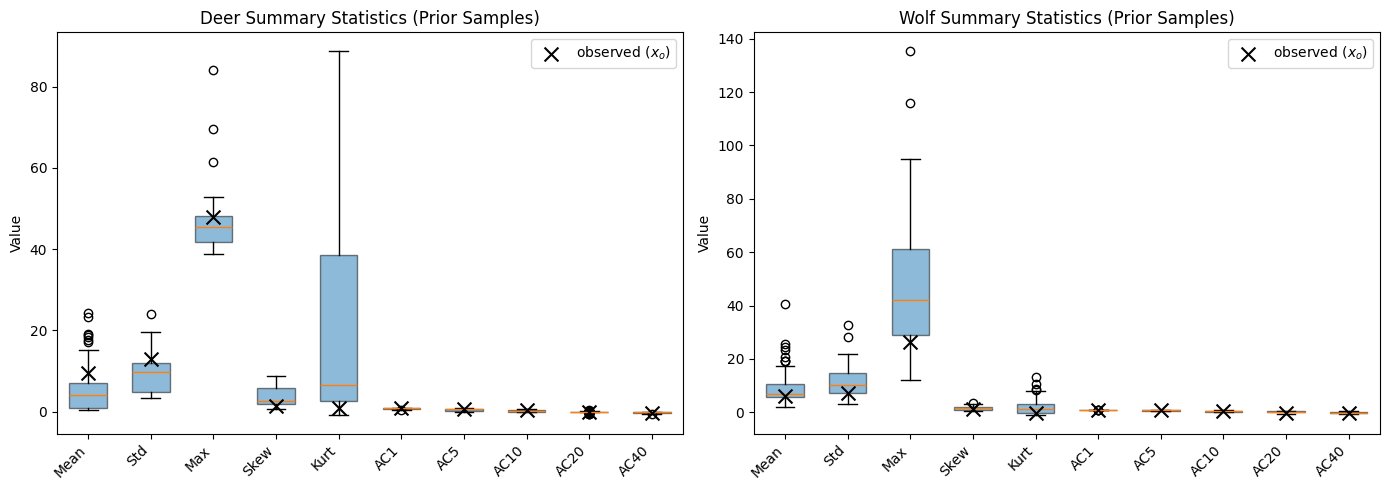

In [3]:
# Compute summary statistics for prior samples (with autocorrelation)
x_prior = lotka_volterra_simulator(theta_prior, use_autocorrelation=True)

print(f"Summary statistics shape: {x_prior.shape}")  # Should be (100, 20)
print(f"Observed summary statistics shape: {x_o.shape}")

# Visualize summary statistics distribution
stat_names = ["Mean", "Std", "Max", "Skew", "Kurt", "AC1", "AC5", "AC10", "AC20", "AC40"]
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Deer statistics
ax = axes[0]
positions = np.arange(10)
bp = ax.boxplot(x_prior[:, :10].numpy(), positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
ax.scatter(positions, x_o.squeeze()[:10].numpy(), color="k", s=100, zorder=10, marker="x", label=r"observed ($x_o$)")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names, rotation=45, ha='right')
ax.set_title("Deer Summary Statistics (Prior Samples)")
ax.set_ylabel("Value")
ax.legend()

# Wolf statistics
ax = axes[1]
bp = ax.boxplot(x_prior[:, 10:20].numpy(), positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
ax.scatter(positions, x_o.squeeze()[10:20].numpy(), color="k", s=100, zorder=10, marker="x", label=r"observed ($x_o$)")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names, rotation=45, ha='right')
ax.set_title("Wolf Summary Statistics (Prior Samples)")
ax.set_ylabel("Value")
ax.legend()

plt.tight_layout()
plt.show()

## Now Let's Implement ABC!

We've explored the simulator and understand our summary statistics. Now it's time to implement rejection ABC to infer the parameters θ from observed data x_o.

In [4]:
# Helper functions for ABC (provided)

def distance(x: Tensor, x_o: Tensor) -> Tensor:
    """Compute mean squared error between simulated and observed summary statistics."""
    return torch.mean((x - x_o) ** 2, dim=-1)

def sample_and_simulate(num_samples: int) -> tuple[Tensor, Tensor]:
    """Sample parameters from prior and simulate summary statistics."""
    theta = prior.sample((num_samples,))
    x = lotka_volterra_simulator(theta, use_autocorrelation=True)
    return theta, x

### Think First! 🤔

Before we implement ABC, consider these questions:

1. **What happens as ε → 0?** (very small threshold)
2. **What happens as ε → ∞?** (very large threshold)
3. **What's the trade-off we're making with ε?**

<details>
<summary>Click to reveal answers</summary>

1. **ε → 0**: Only exact matches accepted → true posterior, but acceptance rate → 0
2. **ε → ∞**: Everything accepted → posterior = prior (no information gained)
3. **Trade-off**: Accuracy vs. computational efficiency (acceptance rate)

</details>

### Rejection ABC Algorithm

**Goal**: Approximate the posterior $p(\theta | x_o)$ by accepting parameters whose simulations are "close" to the observation.

**Algorithm**:
```
for i = 1 to N:
    1. Sample θ from prior: θ ~ p(θ)
    2. Simulate data: x ~ p(x | θ)  
    3. If distance(x, x_o) < ε: accept θ
```

**Key choices**:
- **Distance function** $d(x, x_o)$: How to measure similarity (e.g., MSE on summary stats)
- **Threshold** $\varepsilon$: Trade-off between accuracy and acceptance rate

As $\varepsilon \to 0$, the ABC posterior converges to the true posterior.

## Task: Implement Rejection ABC

Implement the rejection ABC algorithm:
1. Loop through simulation budget
2. Sample θ from prior, simulate x
3. Accept θ if distance(x, x_o) < ε
4. Return accepted samples

### Your Task: Implement the rejection ABC loop

Complete the function below. The key logic is:
- Sample θ from prior
- Simulate summary statistics x
- Accept θ if it produces x "close enough" to x_o

In [6]:
def rejection_abc(num_simulations: int, epsilon: float) -> tuple[Tensor, Tensor]:
    """Run rejection ABC and return accepted posterior samples.
    
    Args:
        num_simulations: Total number of simulations to run
        epsilon: Acceptance threshold for distance
        
    Returns:
        posterior_samples: Accepted θ values
        all_theta: All sampled θ values (for visualization)
    """
    accepted = []
    all_theta = []
    
    for _ in trange(num_simulations):
        # Step 1: Sample from prior and simulate
        # Make sure to use lotka_volterra_simulator(theta, use_autocorrelation=True)
        
        # Step 2: Accept if close enough to observation
        # TODO: Your code here - when should we accept theta?
        pass
    
    return torch.cat(accepted), torch.cat(all_theta)

In [7]:
# %load solutions/solutions_nb_2a_1.py

### Run ABC with different ε values

Now run your implementation! Start with ε=5 and experiment.

In [8]:
# Run rejection ABC
# Note: This takes ~1 minute for 10,000 simulations

# # YOUR CODE HERE: set epsilon and run your function.
eps = ...
num_simulations = 5000

posterior_samples, theta = rejection_abc(num_simulations, eps)

100%|██████████| 5000/5000 [00:00<00:00, 7471150.69it/s]


RuntimeError: torch.cat(): expected a non-empty list of Tensors

### Quick Check: Acceptance Rate

What fraction of your simulations led to accepted parameter sets? This tells us how "efficient" ABC is for this problem.

In [ ]:
# What fraction of simulations were accepted?

# YOUR CODE HERE (hint: use len() and the variables from above)
acceptance_rate = 

print(f"Acceptance rate: {acceptance_rate:.1%}")
print(f"This means {100 - 100*acceptance_rate:.0f}% of simulations were 'wasted'!")

### Think First! 🤔

Before we move on and try out many different epsilons: 

**Can you think of a less wasteful way of implementing the rejection ABC function?**

<details>
<summary>Click to reveal answers</summary>

Let's change the signature to take pre-simulated `theta` and `x` so that we can re-use simulations.

```python
def rejection_abc_smart(theta: Tensor, x: Tensor, epsilon: float) -> tuple[Tensor, Tensor]:
    """Run rejection ABC and return accepted posterior samples."""
    accepted = []

    for theta_i, x_i in zip(theta, x):
        if distance(x_i, x_o) < epsilon:
            accepted.append(theta_i)

    if not len(accepted):
        raise ValueError("No parameters were accepted, epsilon likely too small")
    
    return torch.stack(accepted)
```

</details>

In [ ]:
# %load solutions/solutions_nb_2a_2.py

## Exercise 2: Finding a good ε value

In practice we need find a specific ε value, given a certain simulation budget or desired number of posterior samples. 

Let's say we have a budget of **20_000** simulations, which epsilon should we choose to obtain **200** posterior samples? 

### Your task

- Simulate 20_000 LV traces and save them in `theta` and `x`.
- Using the `rejection_abc_smart` function (copy it from the solution cell above), find an ε such that we obtain around 200 posterior samples.

In [ ]:
# Pre-simulate

num_simulations = 20_000

# TODO: your could goes here
theta = []
x = []

# loop with progress bar.
for _ in trange(num_simulations):
    # theta_i = ...
    # x_i = ...
    
    theta.append(theta_i)
    x.append(x_i)

# Collect lists into tensors.
theta = torch.cat(theta)
x = torch.cat(x)

In [ ]:
# Experiment with different epsilon values

# TODO: fill in epsilon values to try here.
# Hint: use values between 20 and 0.1
epsilon_values = []
results = {}

for eps in epsilon_values:
    # Note: here we just re-use our simulations from above.
    samples = rejection_abc_smart(theta, x, eps)
    results[eps] = samples
    
# Plot comparison
param_idx = 2  # let's visualize the delta param 
fig, axes = plt.subplots(1, len(epsilon_values), figsize=(15, 3))
for ax, eps in zip(axes, epsilon_values):
    ax.hist(results[eps][:, param_idx], bins=20, alpha=0.7, density=True)
    ax.axvline(theta_o[param_idx].item(), color="k", linestyle="--")
    ax.set_title(f"ε = {eps}\n({len(results[eps])} samples)")
    ax.set_xlabel(r"$\delta$")
    ax.set_xlim([0.005, 0.03])
plt.suptitle(r"Effect of ε on posterior for $\delta$ (predator birth rate)")
plt.tight_layout()
plt.show()

In [ ]:
# Final step: Select your epsilon and get posterior samples

final_epsilon = ???
posterior_samples = rejection_abc_smart(theta, x, final_epsilon)

## Visualizing multi-dimensional posteriors

Above, we plotted the histograms for a single parameter. How can we visualize the full four-dimensional posterior? 

We cannot! 

Instead, below we generate a so-colled corner plot or "pairplot". It it shows: 

- on the diagonal: the one-dimensional marginal samples of each parameter
- on the off-diagonal: each pair of two-dimensional marginals posterior samples


In [ ]:
from utils import corner_plot

In [ ]:
param_names = [r"$\alpha$", r"$\beta$", r"$\delta$", r"$\gamma$"]

corner_plot([theta[:2000], posterior_samples], # pass a list of samples to plot.
            labels=["prior", "posterior"], 
            theta_true=theta_o, 
            param_names=param_names,
           );
plt.suptitle("Prior vs. Posteriors Samples", y=1.02, fontsize=12);

## How good is this approximation? *The Posterior Predictive Check*

A key validation step in SBI: do simulations from posterior samples produce data similar to the observation?

We'll compare:
1. **Time series**: Population dynamics from posterior samples vs. ground truth
2. **Summary statistics**: Distribution of summary stats from posterior vs. observed values

In [ ]:
# Posterior predictive check: simulate from posterior samples and compare with observation

# Number of posterior samples to use for predictive check
n_predictive = min(50, len(posterior_samples))
posterior_subset = posterior_samples[:n_predictive]

# Simulate time series for ground truth and posterior samples
time = np.arange(0, 200, 0.1)  # Same as in simulate()
ts_observed = simulate(theta_o.numpy())
ts_posterior = [simulate(posterior_subset[i].numpy()) for i in range(n_predictive)]

# Simulate summary statistics for posterior samples (with autocorrelation)
x_posterior = lotka_volterra_simulator(posterior_subset, use_autocorrelation=True)

# Create figure with 2 rows: time series (top), summary statistics (bottom)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Top row: Time series ---
# Left: Prey (Deer) population
ax = axes[0, 0]
for ts in ts_posterior:
    ax.plot(time, ts[:, 0], color="C1", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 0], color="k", linewidth=2, label="observed (ground truth)")
ax.plot([], [], color="C1", alpha=0.5, label="posterior predictive")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("Prey (Deer) Population")
ax.legend()

# Right: Predator (Wolf) population
ax = axes[0, 1]
for ts in ts_posterior:
    ax.plot(time, ts[:, 1], color="C1", alpha=0.2, linewidth=0.5)
ax.plot(time, ts_observed[:, 1], color="k", linewidth=2, label="observed (ground truth)")
ax.plot([], [], color="C1", alpha=0.5, label="posterior predictive")
ax.set_xlabel("Time (days)")
ax.set_ylabel("Population")
ax.set_title("Predator (Wolf) Population")
ax.legend()

# --- Bottom row: Summary statistics ---
stat_names = ["Mean", "Std", "Max", "Skew", "Kurt", "AC1", "AC5", "AC10", "AC20", "AC40"]
x_obs = x_o.squeeze().numpy()

# Left: Deer summary statistics
ax = axes[1, 0]
deer_stats_posterior = x_posterior[:, :10].numpy()
positions = np.arange(10)
bp = ax.boxplot(deer_stats_posterior, positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C1')
    patch.set_alpha(0.5)
ax.scatter(positions, x_obs[:10], color="k", s=100, zorder=10, marker="x", label="observed")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names, rotation=45, ha='right')
ax.set_title("Deer Summary Statistics")
ax.set_ylabel("Value")
ax.legend()

# Right: Wolf summary statistics
ax = axes[1, 1]
wolf_stats_posterior = x_posterior[:, 10:20].numpy()
bp = ax.boxplot(wolf_stats_posterior, positions=positions, widths=0.6, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('C1')
    patch.set_alpha(0.5)
ax.scatter(positions, x_obs[10:20], color="k", s=100, zorder=10, marker="x", label="observed")
ax.set_xticks(positions)
ax.set_xticklabels(stat_names, rotation=45, ha='right')
ax.set_title("Wolf Summary Statistics")
ax.set_ylabel("Value")
ax.legend()

plt.tight_layout()
plt.show()

### Conclusions

- finding a good trade-off between simulation budget and number of accepted posterior samples is difficult!
- posterior predictive check: our simulations from the posterior center on the observed summary statistics, but the corresponding time-series show a lot of variance
- we would need more simulations and a smaller epsilon! 

## Summary

### Advantages of ABC

- Conceptually simple: fast to implement and apply
- No neural network training required
- Works with any simulator that can generate samples

### Disadvantages of ABC

- Curse of dimensionality: struggles with high-dimensional $\theta$ or $x$
- Ad-hoc choices needed: distance metric, rejection threshold $\epsilon$, summary statistics
- Many simulations "wasted" on rejected samples
- Not amortized: must re-run for each new observation $x_o$

## Learning Goals

At this point you should understand:

- What is a simulation-based model / simulator?
- Why do we need to infer parameters?
- What is Bayesian inference, and why is it better than point estimates?
- Why can't we just use MCMC when we have a simulator?
- What is simulation-based inference?
- How does rejection ABC work?
- What are the benefits and downsides of rejection ABC?

### Connect to Your Problem 🔗

Now think about your own simulator:

| Question | Consider |
|----------|----------|
| **Parameter dimension** | ABC struggles with dim(θ) > 10. How many parameters do you have? |
| **Simulation cost** | ABC needs many simulations. How long does one run of your simulator take? |
| **Summary statistics** | What features of your output would you use? Are they sufficient? |
| **Distance metric** | Is MSE appropriate, or do you need domain-specific distances? |

**Rule of thumb**: ABC is a good starting point if:
- θ is low-dimensional (< 10 parameters)
- Simulator runs in < 1 second  
- You have good intuition for summary statistics

## Questions?

Feel free to ask about any concepts covered in this notebook.

## Next: Neural Posterior Estimation (NPE)

Use *conditional density estimation* to learn a parametric approximation to the posterior distribution.

Instead of rejection sampling, train a neural network $q_\phi(\theta|x)$ to directly approximate $p(\theta|x)$.

---

**Continue to the next notebook** to learn about conditional density estimation and neural posterior estimation (NPE).